# AI Club Task Submission
#### Name: Tanish Jain
#### BITS ID: 2025AAPS0776P

In [1]:
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

In [2]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

##### Replace the path with the path of the audio files on your device

In [3]:
def load_clean_fixed(path, sr=22050, duration=3.0):
    y, sr = librosa.load(path, sr=sr)
    y, _ = librosa.effects.trim(y, top_db=20)

    target_len = int(sr * duration)

    if len(y) > target_len:
        y = y[:target_len]
    else:
        y = np.pad(y, (0, target_len - len(y)))

    return y, sr

In [4]:
def wav_to_logmel(y, sr, n_mels=128):
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=2048,
        hop_length=512,
        n_mels=n_mels
    )

    logmel = librosa.power_to_db(mel, ref=np.max)

    # Normalize for stable CNN learning
    logmel = (logmel - np.mean(logmel)) / (np.std(logmel) + 1e-6)

    return logmel

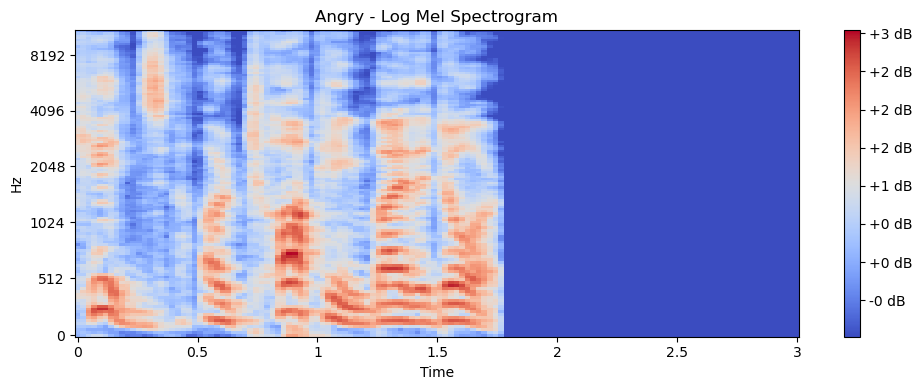

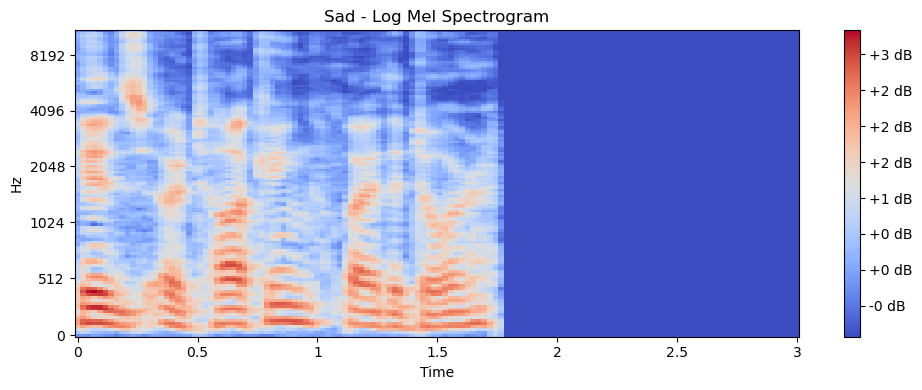

In [5]:
angry_file = r"C:\\College\\Sem2\\SpeechRecognitionRAVDESS\\archive\\Audio_Speech_Actors_01-24\\Actor_01\\03-01-05-01-01-01-01.wav"
sad_file   = r"C:\\College\\Sem2\\SpeechRecognitionRAVDESS\\archive\\Audio_Speech_Actors_01-24\\Actor_01\\03-01-04-01-01-01-01.wav"

y_a, sr = load_clean_fixed(angry_file)
y_s, _  = load_clean_fixed(sad_file)

mel_angry = wav_to_logmel(y_a, sr)
mel_sad   = wav_to_logmel(y_s, sr)

plt.figure(figsize=(10,4))
librosa.display.specshow(mel_angry, sr=sr, x_axis="time", y_axis="mel")
plt.title("Angry - Log Mel Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
librosa.display.specshow(mel_sad, sr=sr, x_axis="time", y_axis="mel")
plt.title("Sad - Log Mel Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

In [6]:
def augment_audio(y, sr):
    choice = random.choice(["noise", "pitch", "stretch", "none"])

    if choice == "noise":
        noise_amp = 0.005 * np.random.uniform() * np.amax(y)
        y = y + noise_amp * np.random.normal(size=y.shape[0])

    elif choice == "pitch":
        steps = random.uniform(-2, 2)
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)

    elif choice == "stretch":
        rate = random.uniform(0.8, 1.2)
        y = librosa.effects.time_stretch(y, rate=rate)

        # Fix back to 3 seconds
        target_len = int(sr * 3)
        if len(y) > target_len:
            y = y[:target_len]
        else:
            y = np.pad(y, (0, target_len - len(y)))

    return y


wav_paths = []
labels = []
genders = []

root = r"C:\College\Sem2\SpeechRecognitionRAVDESS\archive\Audio_Speech_Actors_01-24"

for actor in os.listdir(root):
    actor_path = os.path.join(root, actor)

    for file in os.listdir(actor_path):
        if not file.endswith(".wav"):
            continue

        parts = file.split("-")
        emotion_code = parts[2]
        actor_id = int(parts[6].split(".")[0])

        wav_paths.append(os.path.join(actor_path, file))
        labels.append(emotion_map[emotion_code])
        genders.append("male" if actor_id % 2 else "female")

print("Total samples:", len(wav_paths))

Total samples: 1440


In [7]:
le = LabelEncoder()
y_int = le.fit_transform(labels)

train_paths, temp_paths, train_labels, temp_labels, train_g, temp_g = train_test_split(
    wav_paths, labels, genders,
    test_size=0.2,
    stratify=y_int,
    random_state=42
)

val_paths, test_paths, val_labels, test_labels, val_g, test_g = train_test_split(
    temp_paths, temp_labels, temp_g,
    test_size=0.5,
    stratify=le.transform(temp_labels),
    random_state=42
)

print("Train:", len(train_paths))
print("Val:", len(val_paths))
print("Test:", len(test_paths))

Train: 1152
Val: 144
Test: 144


In [8]:
def build_X(paths, augment=False):
    X_out = []

    for p in paths:
        y_wave, sr = load_clean_fixed(p)

        if augment:
            y_wave = augment_audio(y_wave, sr)

        mel = wav_to_logmel(y_wave, sr)
        X_out.append(mel)

    X_out = np.array(X_out)[..., np.newaxis]
    return X_out


X_train = build_X(train_paths, augment=False)
X_val   = build_X(val_paths, augment=False)
X_test  = build_X(test_paths, augment=False)

y_train = to_categorical(le.transform(train_labels))
y_val   = to_categorical(le.transform(val_labels))
y_test  = to_categorical(le.transform(test_labels))

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1152, 128, 130, 1)
X_val shape: (144, 128, 130, 1)
X_test shape: (144, 128, 130, 1)


In [9]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Conv2D(64, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Conv2D(256, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.5),

    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),

    Dense(8, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

C:\Users\Tanish\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 130, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 130, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 65, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 65, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 65, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 65, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,0

 Total params: 423,688 (1.62 MB)

 Trainable params: 422,728 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 692ms/step - accuracy: 0.2578 - loss: 2.1009 - val_accuracy: 0.1389 - val_loss: 2.6094
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 693ms/step - accuracy: 0.3628 - loss: 1.8889 - val_accuracy: 0.1389 - val_loss: 3.5250
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 665ms/step - accuracy: 0.3655 - loss: 1.7994 - val_accuracy: 0.1736 - val_loss: 3.5377
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 665ms/step - accuracy: 0.3845 - loss: 1.7278 - val_accuracy: 0.1736 - val_loss: 4.7624
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 657ms/step - accuracy: 0.4332 - loss: 1.6317 - val_accuracy: 0.1319 - val_loss: 7.3886
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 653ms/step - accuracy: 0.4349 - loss: 1.6198 - val_accuracy: 0.1319 - val_loss: 8.8751
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 655ms/step - accuracy: 0.4557 - loss: 1.5723 - val_accuracy: 0.1319 - val_loss: 9.1736
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 658ms/step - accuracy: 0.4792 - loss: 1.4875 - val_accu

In [11]:
y_pred = model.predict(X_test)

y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test, axis=1)

print("Macro F1:", f1_score(y_true_cls, y_pred_cls, average="macro"))
print(classification_report(y_true_cls, y_pred_cls, target_names=le.classes_))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step
Macro F1: 0.5341792890516759
              precision    recall  f1-score   support

       angry       0.80      0.63      0.71        19
        calm       0.75      0.47      0.58        19
     disgust       0.71      0.89      0.79        19
     fearful       0.67      0.60      0.63        20
       happy       0.41      0.68      0.51        19
     neutral       0.36      0.90      0.51        10
         sad       0.56      0.53      0.54        19
   surprised       0.00      0.00      0.00        19

    accuracy                           0.57       144
   macro avg       0.53      0.59      0.53       144
weighted avg       0.54      0.57      0.54       144



C:\Users\Tanish\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Tanish\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Tanish\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


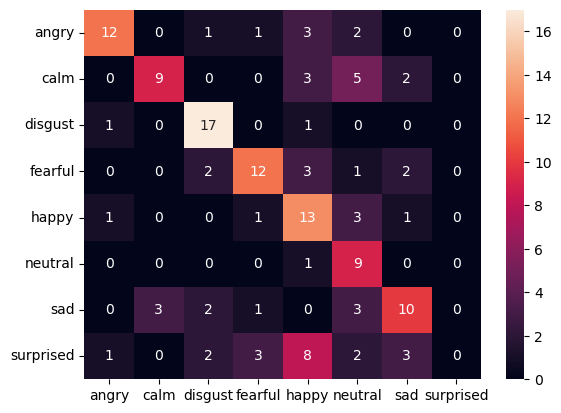

In [12]:
cm = confusion_matrix(y_true_cls, y_pred_cls)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.show()

In [13]:
male_idx = [i for i,g in enumerate(test_g) if g=="male"]
female_idx = [i for i,g in enumerate(test_g) if g=="female"]

print("Male Macro F1:",
      f1_score(y_true_cls[male_idx], y_pred_cls[male_idx], average="macro"))

print("Female Macro F1:",
      f1_score(y_true_cls[female_idx], y_pred_cls[female_idx], average="macro"))

Male Macro F1: 0.5170435376027481
Female Macro F1: 0.5695238095238095


In [14]:
model.save("emotion_cnn.keras")